In [2]:
def split(name):
    import numpy as np
    from pandas import read_csv, concat, unique, DataFrame
    import matplotlib.pyplot as plt
    import ds_charts as ds
    from ds_charts import multiple_bar_chart
    from sklearn.model_selection import train_test_split

    #approach = number
    #dict = {1: data_mv_drop_variables, 2: data_mv_other}
    dataset = name.copy()

    target = 'class'
    values = {}

    y = dataset.pop(target).values
    X = dataset.values
    labels = unique(y)
    labels.sort()

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=0)

    train = concat([DataFrame(trnX, columns=dataset.columns), DataFrame(trnY,columns=[target])], axis=1)
    train.to_csv(f'datasets/drought_train.csv', index=False)

    test = concat([DataFrame(tstX, columns=dataset.columns), DataFrame(tstY,columns=[target])], axis=1)
    test.to_csv(f'datasets/drought_test.csv', index=False)
    
    values['Train'] = [len(np.delete(trnY, np.argwhere(trnY!=0))), len(np.delete(trnY, np.argwhere(trnY!=1)))]
    values['Test'] = [len(np.delete(tstY, np.argwhere(tstY!=0))), len(np.delete(tstY, np.argwhere(tstY!=1)))]

    #plt.figure(figsize=(12,4))
    #multiple_bar_chart(['0','1'], values, title='Data distribution per dataset')
    #plt.show()

    return [trnX, tstX, trnY, tstY]

In [3]:
import pandas as pd
from ds_charts import bar_chart

dataset = pd.read_csv('datasets/drought_prepared.csv')
splitted = split(dataset)

# Decision trees

<Figure size 600x450 with 0 Axes>

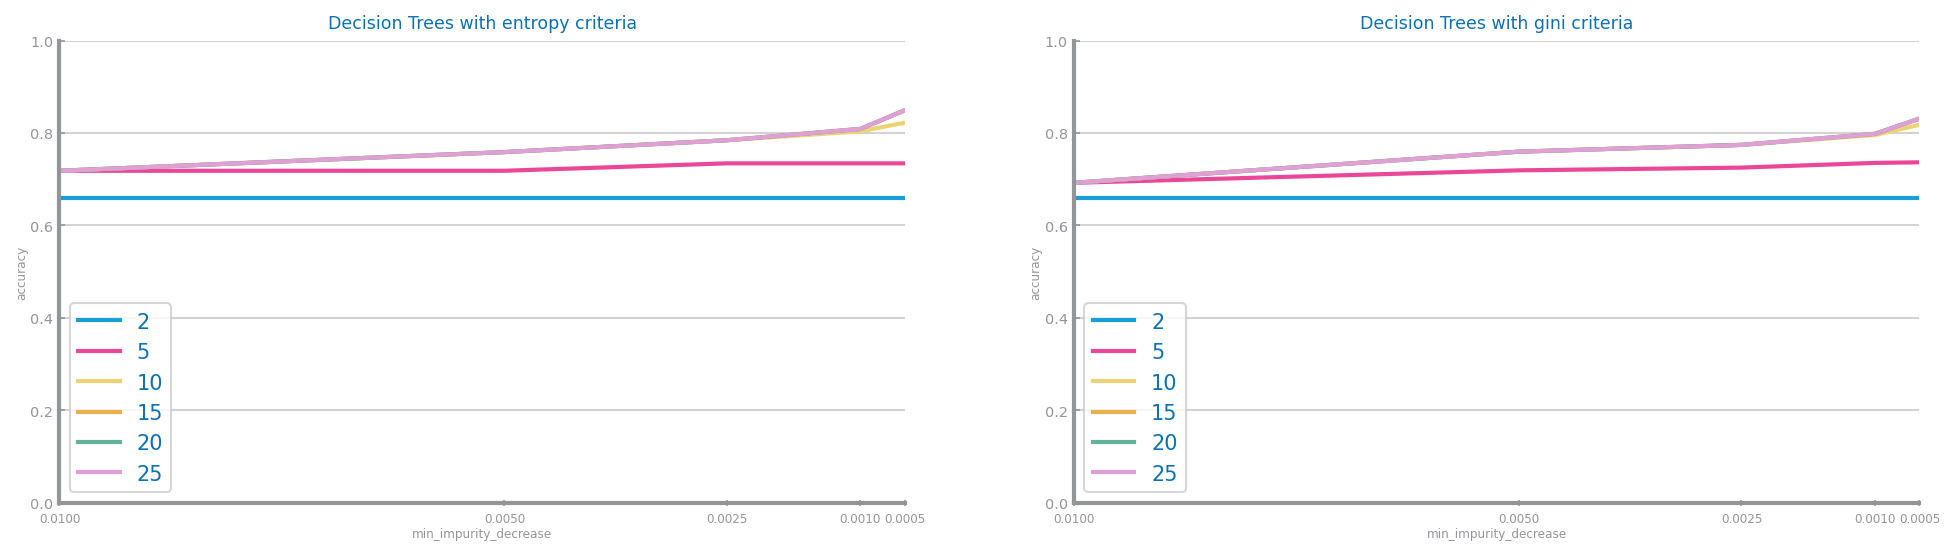

In [4]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, subplots, savefig, show
from sklearn.tree import DecisionTreeClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score

file_tag = 'drought'
filename = 'datasets/drought'
target = 'class'

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

min_impurity_decrease = [0.01, 0.005, 0.0025, 0.001, 0.0005]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_model = None

figure()
fig, axs = subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_model = tree

        values[d] = yvalues
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title=f'Decision Trees with {f} criteria',
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
savefig(f'images/{file_tag}_dt_study.png')
show()


In [5]:
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.5f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

Best results achieved with entropy criteria, depth=15 and min_impurity_decrease=0.00050 ==> accuracy=0.85


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.31291 to fit


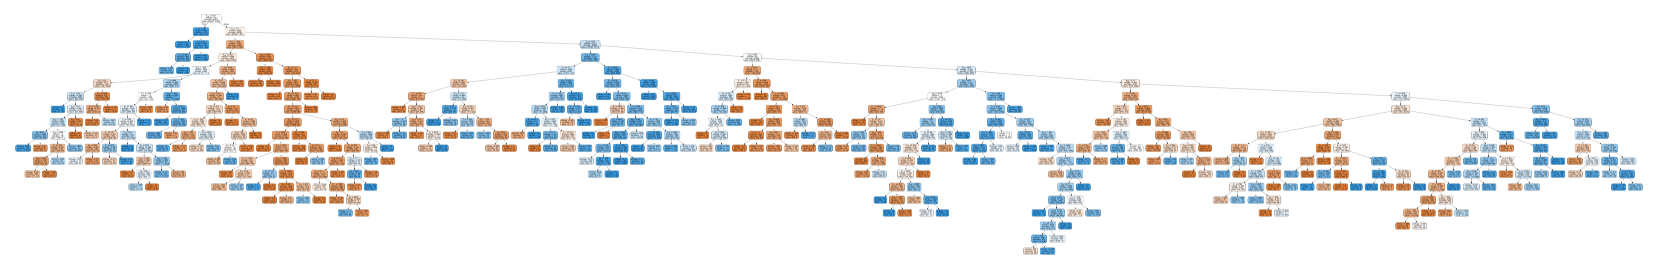

In [28]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis

file_tree = 'images/drought_dt_best_tree.png'

dot_data = export_graphviz(best_model, out_file='images/drought_dt_best_tree.dot', filled=True, rounded=True, special_characters=True)
from subprocess import call
call(['dot', '-Tpng', 'images/best_tree.dot', '-o', file_tree, '-Gdpi=600'])

figure(figsize = (14, 18))
imshow(imread(file_tree))
axis('off')
show()

0.8663221153846153 0.8492904817993158
0.8870346598202824 0.8721988018637675
0.8451402732532698 0.8258650028360749
0.8541800201446754 0.8366499946791529


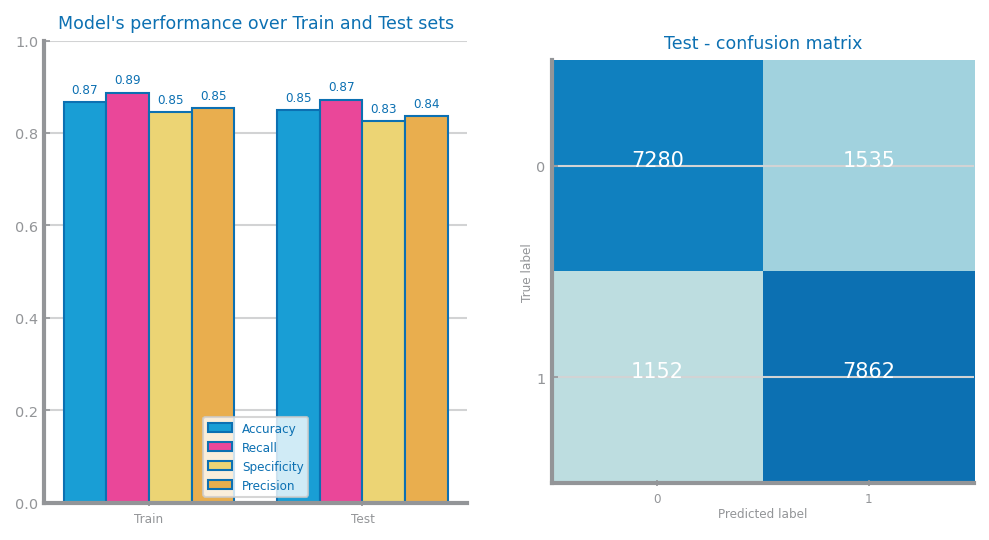

In [6]:
from ds_charts import plot_evaluation_results, multiple_line_chart

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_dt_best.png')
show()

1. feature year (0.4957637332700066)
2. feature month (0.12306995678603978)
3. feature T2M_MAX (0.07123912015509588)
4. feature TS (0.0368237789615672)
5. feature PRECTOT (0.035458541626215694)
6. feature T2M_MIN (0.031920002196494345)
7. feature T2M (0.026959635533990917)
8. feature PS (0.025857439234225003)
9. feature T2M_RANGE (0.02027594341957975)
10. feature QV2M (0.01987309246973394)
11. feature WS50M_MIN (0.013199024608015685)
12. feature WS10M_RANGE (0.010913284337262139)
13. feature WS50M_MAX (0.010719968264655906)
14. feature T2MWET (0.009737086098285339)
15. feature WS50M_RANGE (0.009131229261632998)
16. feature fips (0.0077586609520576295)
17. feature WS50M (0.006511865834821691)
18. feature aspectS (0.0052662632914514465)
19. feature slope5 (0.004979277212431594)
20. feature lon (0.004576361061208434)
21. feature WS10M (0.003285813747305918)
22. feature slope1 (0.0032062378612531884)
23. feature WS10M_MAX (0.0029269243883957375)
24. feature aspectW (0.0028185109471765618)


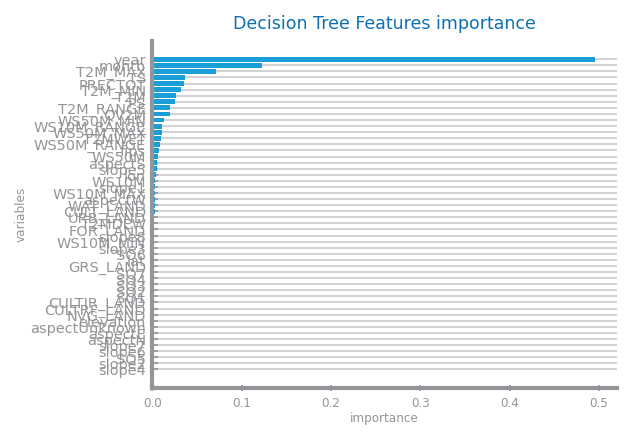

In [7]:
from numpy import argsort, arange
from ds_charts import horizontal_bar_chart
from matplotlib.pyplot import Axes

variables = train.columns
importances = best_model.feature_importances_
indices = argsort(importances)[::-1]
elems = []
imp_values = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
horizontal_bar_chart(elems, imp_values, error=None, title='Decision Tree Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_dt_ranking.png')

## Decision trees - overfitting

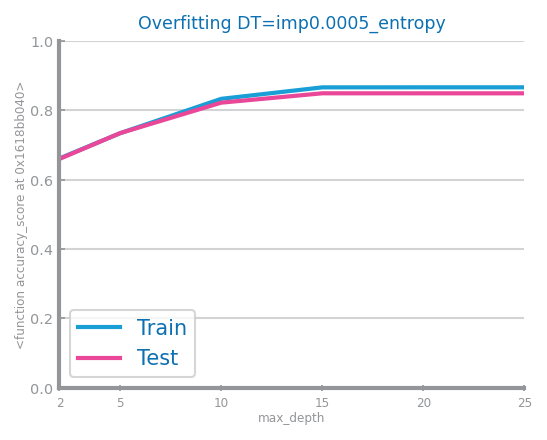

In [13]:
from ds_charts import plot_overfitting_study
#best[1] contém o melhor valor para a max_depth
imp = best[2]
f = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for d in max_depths:
    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prd_tst_Y = tree.predict(tstX)
    prd_trn_Y = tree.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'DT=imp{imp}_{f}', xlabel='max_depth', ylabel=str(eval_metric))

# Random forests

0 0.3 5
0 0.3 10
0 0.3 25
0 0.3 50
0 0.3 75
0 0.3 100
0 0.3 200
0 0.3 300
0 0.3 400
0 0.5 5
0 0.5 10
0 0.5 25
0 0.5 50
0 0.5 75
0 0.5 100
0 0.5 200
0 0.5 300
0 0.5 400
0 0.7 5
0 0.7 10
0 0.7 25
0 0.7 50
0 0.7 75
0 0.7 100
0 0.7 200
0 0.7 300
0 0.7 400
0 1 5
0 1 10
0 1 25
0 1 50
0 1 75
0 1 100
0 1 200
0 1 300
0 1 400
1 0.3 5
1 0.3 10
1 0.3 25
1 0.3 50
1 0.3 75
1 0.3 100
1 0.3 200
1 0.3 300
1 0.3 400
1 0.5 5
1 0.5 10
1 0.5 25
1 0.5 50
1 0.5 75
1 0.5 100
1 0.5 200
1 0.5 300
1 0.5 400
1 0.7 5
1 0.7 10
1 0.7 25
1 0.7 50
1 0.7 75
1 0.7 100
1 0.7 200
1 0.7 300
1 0.7 400
1 1 5
1 1 10
1 1 25
1 1 50
1 1 75
1 1 100
1 1 200
1 1 300
1 1 400
2 0.3 5
2 0.3 10
2 0.3 25
2 0.3 50
2 0.3 75
2 0.3 100
2 0.3 200
2 0.3 300
2 0.3 400
2 0.5 5
2 0.5 10
2 0.5 25
2 0.5 50
2 0.5 75
2 0.5 100
2 0.5 200
2 0.5 300
2 0.5 400
2 0.7 5
2 0.7 10
2 0.7 25
2 0.7 50
2 0.7 75
2 0.7 100
2 0.7 200
2 0.7 300
2 0.7 400
2 1 5
2 1 10
2 1 25
2 1 50
2 1 75
2 1 100
2 1 200
2 1 300
2 1 400


<Figure size 600x450 with 0 Axes>

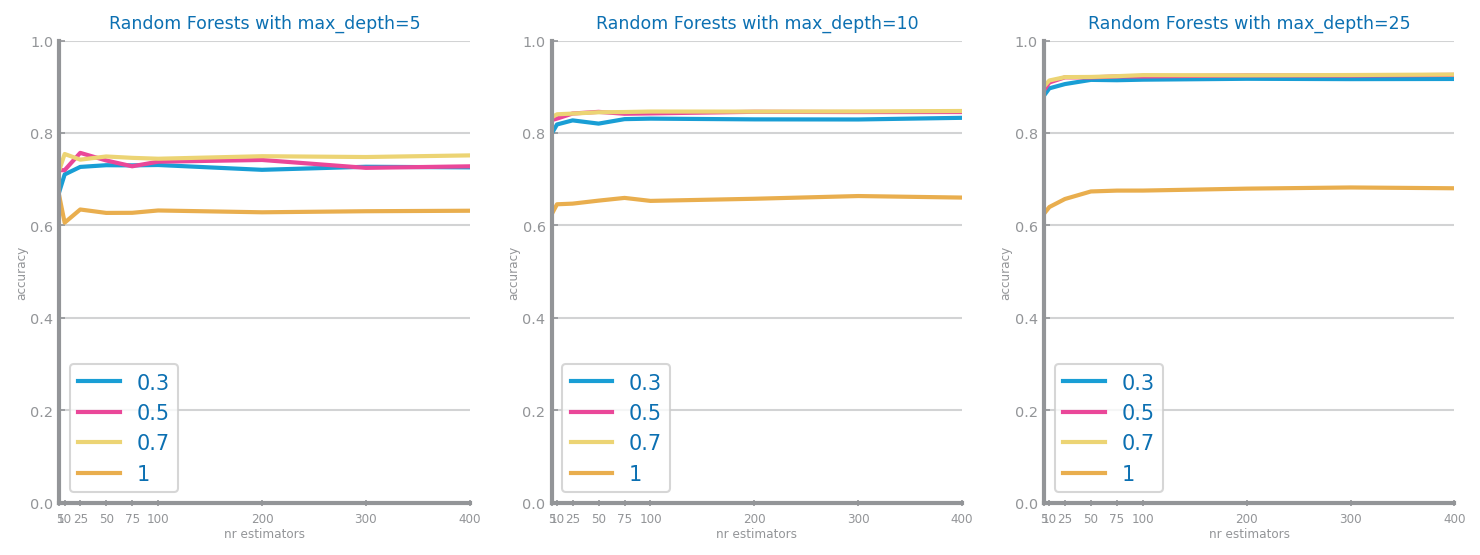

In [14]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, subplots, savefig, show
from sklearn.ensemble import RandomForestClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, horizontal_bar_chart, HEIGHT
from sklearn.metrics import accuracy_score

file_tag = 'drought'
filename = 'datasets/drought'
target = 'class'

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
figure()
fig, axs = subplots(1, cols, figsize=(cols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            print(k, f, n)
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
savefig(f'images/{file_tag}_rf_study.png')
show()

In [15]:
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

Best results with depth=25, 0.70 features and 400 estimators, with accuracy=0.93


1.0 0.9264681137472657
1.0 0.9370978477923231
1.0 0.9155984117980714
1.0 0.9190512457839191


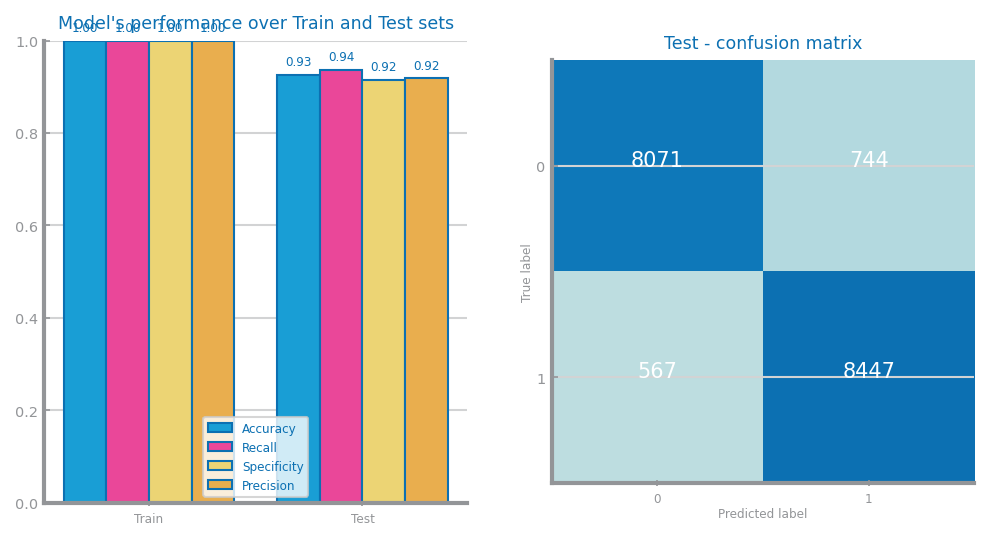

In [16]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig(f'images/{file_tag}_rf_best.png')
show()

1. feature year (0.32980061074016603)
2. feature month (0.07016478885687116)
3. feature T2M_MAX (0.0667500476860227)
4. feature T2M_RANGE (0.04137637008877534)
5. feature PS (0.03649133531833854)
6. feature T2M_MIN (0.031516431420589686)
7. feature PRECTOT (0.03103638938518223)
8. feature TS (0.030882048171525827)
9. feature T2M (0.02739907104419948)
10. feature WS50M_RANGE (0.026236252405566)
11. feature QV2M (0.025967141828093437)
12. feature WS50M_MAX (0.02474018783327611)
13. feature WS10M_RANGE (0.02222599520855007)
14. feature WS50M (0.02184989384358005)
15. feature T2MDEW (0.01976563702181472)
16. feature WS50M_MIN (0.019391597062269603)
17. feature T2MWET (0.018758654876979784)
18. feature WS10M_MIN (0.015611472917525652)
19. feature WS10M_MAX (0.01464819627447406)
20. feature WS10M (0.013448947487289815)
21. feature fips (0.009448547209685187)
22. feature URB_LAND (0.006392979321494381)
23. feature CULT_LAND (0.006349044163816156)
24. feature lat (0.006239381855479545)
25. fea

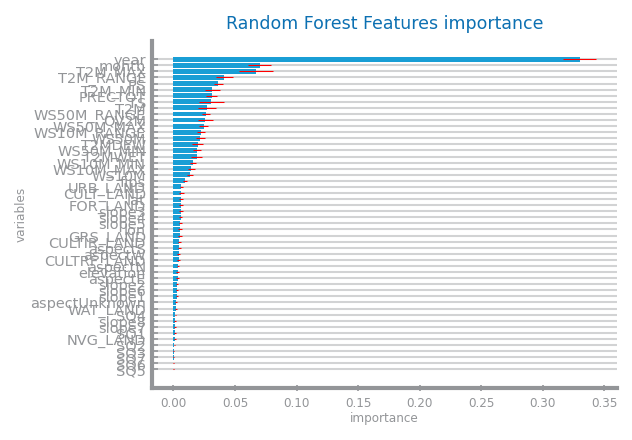

In [17]:
from numpy import std, argsort

variables = train.columns
importances = best_model.feature_importances_
stdevs = std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

figure()
horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
savefig(f'images/{file_tag}_rf_ranking.png')

## Random forests - overfitting

5
10
25
50
75
100
200
300
400


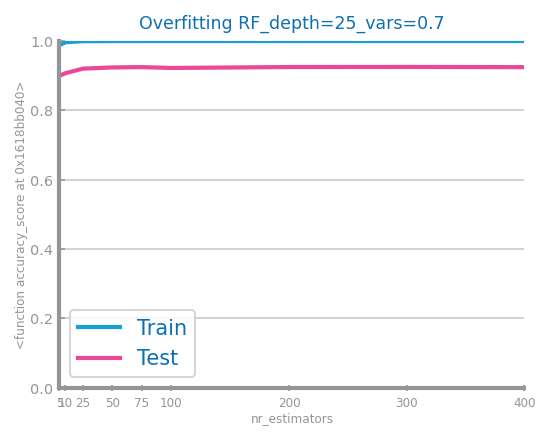

In [20]:
from ds_charts import plot_overfitting_study

f = best[1]
max_depth = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    print(n)
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'RF_depth={max_depth}_vars={f}', xlabel='nr_estimators', ylabel=str(eval_metric))

# KNN

manhattan 1
manhattan 5
manhattan 11
manhattan 15
manhattan 19
manhattan 21
euclidean 1
euclidean 5
euclidean 11
euclidean 15
euclidean 19
euclidean 21
chebyshev 1
chebyshev 5
chebyshev 11
chebyshev 15
chebyshev 19
chebyshev 21


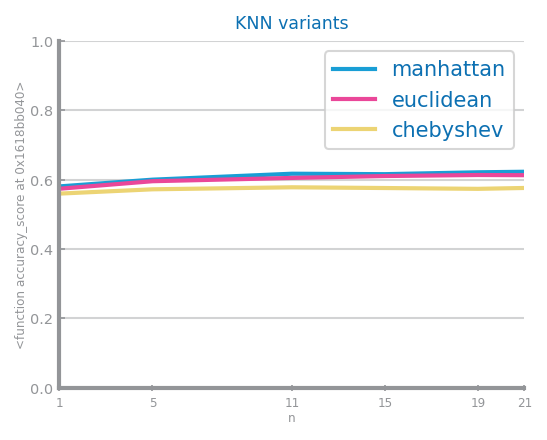

Best results with 21 neighbors and manhattan
0.6806971153846154 0.6227494531381457
0.6448913611943137 0.5906367872198802
0.7173141440171148 0.655587067498582
0.6999690370523274 0.6368421052631579


<Figure size 600x450 with 0 Axes>

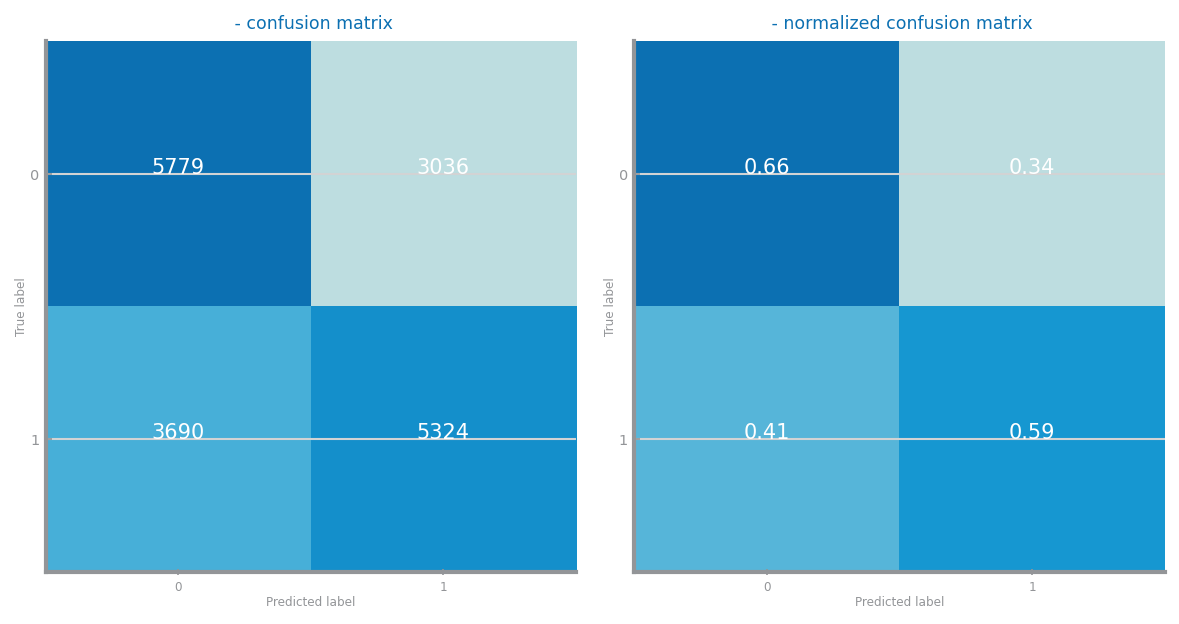

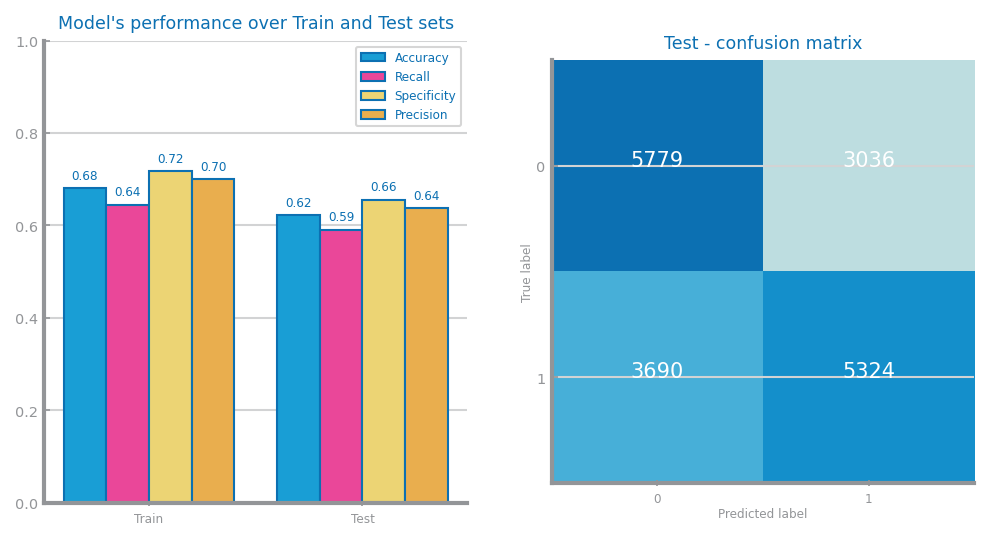

In [23]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, plot_overfitting_study
from sklearn.metrics import accuracy_score
from ds_charts import plot_evaluation_results, bar_chart, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
file_tag = 'drought'
filename = 'datasets/drought'
target = 'class'

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

labels = unique(trnY)
labels.sort()

eval_metric = accuracy_score
nvalues = [1,5,11,15,19,21]
dist = ['manhattan', 'euclidean', 'chebyshev']
KNNscores = {}
best = (0, '')
last_best = 0
for d in dist:
    y_tst_values = []
    for n in nvalues:
        print(d,n)
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prd_tst_Y = knn.predict(tstX)
        y_tst_values.append(eval_metric(tstY, prd_tst_Y))
        if y_tst_values[-1] > last_best:
            best = (n, d)
            last_best = y_tst_values[-1]
    KNNscores[d] = y_tst_values

from ds_charts import multiple_line_chart
figure()
multiple_line_chart(nvalues, KNNscores, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
#savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_tst = clf.predict(tstX)

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,0], )
plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,1], normalize=True)
plt.tight_layout()

clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_tst = clf.predict(tstX)
prd_trn = clf.predict(trnX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

plt.show()

1
5
11
15
19
21


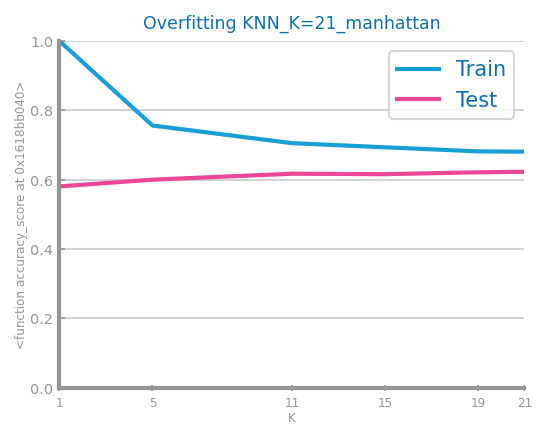

In [25]:
from matplotlib.pyplot import figure, savefig

def plot_overfitting_study(xvalues, prd_trn, prd_tst, name, xlabel, ylabel):
    evals = {'Train': prd_trn, 'Test': prd_tst}
    figure()
    multiple_line_chart(xvalues, evals, ax = None, title=f'Overfitting {name}', xlabel=xlabel, ylabel=ylabel, percentage=True)
    savefig('images/overfitting_{name}.png')

d = best[1]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in nvalues:
    print(n)
    knn = KNeighborsClassifier(n_neighbors=n, metric=d)
    knn.fit(trnX, trnY)
    prd_tst_Y = knn.predict(tstX)
    prd_trn_Y = knn.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
plot_overfitting_study(nvalues, y_trn_values, y_tst_values, name=f'KNN_K={n}_{d}', xlabel='K', ylabel=str(eval_metric))